<a href="https://colab.research.google.com/github/Mikaner/reinforcement/blob/main/Studing_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [3]:
# データのダウンロード
from sklearn.datasets import fetch_openml

mnist_X, mnist_y = fetch_openml('mnist_784', version=1, data_home=".", return_X_y=True)

/usr/local/lib/python3.7/dist-packages/sklearn/datasets/_openml.py:55: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


In [4]:
# 正規化
X = mnist_X / 255
y = mnist_y

This picture has label 5


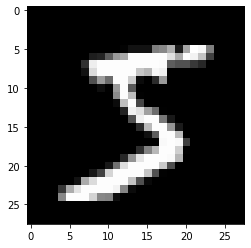

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("This picture has label {:.0f}".format(int(y[0])))

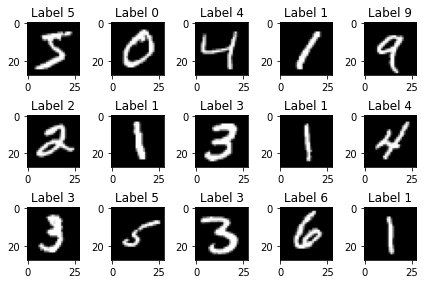

In [34]:
row, col = 3, 5
axes=[]
fig = plt.figure()
for i in range(row*col):
    axes.append( fig.add_subplot(row, col, i+1))
    subplt_title = "Label {:.0f}".format(int(y[i]))
    axes[-1].set_title(subplt_title)
    plt.imshow(X[i].reshape(28,28),cmap='gray')
fig.tight_layout()
plt.show()

In [25]:
# DataLoaderの作成
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train.astype(np.int))
y_test = torch.LongTensor(y_test.astype(np.int))

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# DataLoader（1バッチ64個のデータを持つデータローダを設定する）
# おそらくイテレータブルなオブジェクトで、一つ一つに64個のデータを持っている。
# 1バッチのサイズを64個のデータに設定する
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [37]:
len(y_test)

10000

## ネットワークの構築


<h3><strong>~ Keras風の書き方 ~</strong></h3>

In [38]:
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


<h3><strong>~ Chainer風の書き方 ~</strong></h3>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

model = Net(n_in=28*28*1, n_mid=100, n_out=10)
print(model)

### 誤差関数と最適化手法の設定

In [39]:
# 誤差関数と最適化手法の設定
from torch import optim

# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()

# 重みを学習する際の最適化の手法
optimizer = optim.Adam(model.parameters(), lr=0.01)

## 学習と推論の設定

### 学習1回でやることを定義する

In [40]:
 def train(epoch):
    model.train() # ネットワークを学習モードに切り替える (推論時はmodel.eval())

    # データローダーから1ミニバッチずつ取り出して計算する
    for data, targets in loader_train:
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
        outputs = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(outputs, targets) # 出力と訓練データの正解との誤差を求める

        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step() # バックプロパゲーションの値で重みを更新する

    print("epoch{} : fin\n".format(epoch))

### 推論1回でやることを定義する

In [51]:
def test():
    model.eval() # ネットワークを推論モードに切り替える
    correct = 0

    # データローダーから1ミニバッチずつ取り出して計算する ← バッチじゃない方がどうしたらいいのか。
    with torch.no_grad():  # 微分は推論では必要ない ← いや、no_gradって何。
        for data, targets in loader_test: # おそらく、dataがテストデータ、targetは正解データだと思われます。
            outputs = model(data)

            # 推論する
            _, predicted = torch.max(outputs.data, 1) # 確率が最大のラベルを求める
            correct += predicted.eq(targets.data.view_as(predicted)).sum() # 正解と一緒だったらカウントアップ

    # 正解率の出力
    data_num = len(loader_test.dataset) # データの総数
    print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct, data_num, 100. * correct / data_num))

In [52]:
test()


テストデータの正解率: 1077/10000 (11%)



In [53]:
for epoch in range(3):
    train(epoch)

test()

epoch0 : fin

epoch1 : fin

epoch2 : fin


テストデータの正解率: 9582/10000 (96%)



Prediction result: 4
Currect label is 6


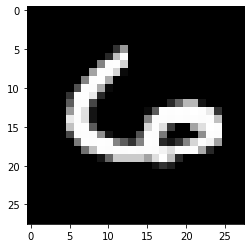

In [57]:
index = 2020

model.eval()
data = X_test[index]
output = model(data)
_, predicted = torch.max(output.data, 0) # 確率が最大のラベルを求める ← 第２引数is何？ ← 推論するdataの形の指定ですって
                                                                                         # 0は1つの画像のみ、1はミニバッチですって

print("Prediction result: {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28,28), cmap='gray')
print("Currect label is {:.0f}".format(y_test[index]))

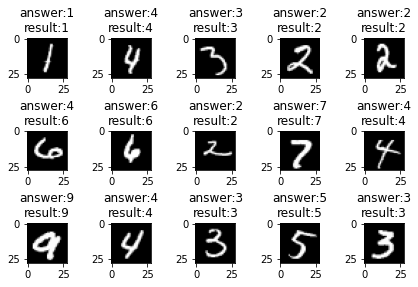

In [69]:
first_index = 2015
row = 3
col = 5
model.eval()

axes = []
fig = plt.figure()

for index in range(first_index, first_index + row*col):
    data = X_test[index]
    output = model(data)
    _, predicted = torch.max(output.data, 0)

    axes.append(fig.add_subplot(row, col, index - first_index + 1))
    subplt_title = "answer:{}\nresult:{}".format(predicted,y_test[index])
    axes[-1].set_title(subplt_title)
    X_test_show = (X_test[index]).numpy()
    plt.imshow(X_test_show.reshape(28,28),cmap='gray')
fig.tight_layout()
plt.show()